# ACCESS surface fluxes

Variables:
- `pme_river` = mass flux of precip-evap+river via sbc (liquid, frozen, evaporation)
   - the equivalent of `wfo` from MOM6 
- `pme_net` = precip-evap into ocean (total w/ restore + normalize)
- `river` = mass flux of river (runoff + calving) entering ocean
- `runoff` = mass flux of liquid river runoff entering ocean
- `evap` = mass flux from evaporation/condensation (>0 enters ocean)
- `melt` = water flux transferred with sea ice form/melt (>0 enters ocean)
- `fprec` = snow falling onto ocean (>0 enters ocean)
- `lprec` = liquid precip (including ice melt/form) into ocean (>0 enters ocean)
- `wfimelt` = water into ocean due to ice melt (>0 enters ocean)
- `wfiform` = water out of ocean due to ice form (>0 enters ocean)
- `sfc_salt_flux_restore` = flux from restoring term
- `sfc_salt_flux_ice` = downward_sea_ice_basal_salt_flux
- `sfc_salt_flux_coupler` = flux from the coupler

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import gsw

In [3]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35045,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45997,Total threads: 1
Dashboard: /proxy/39491/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:43513,


In [4]:
#Importing data
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean_month.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean_month.nc'))

pathsC2 = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM2 = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
lat_slice = slice(-80,-59)
time_slice = slice('1910-01-01','1919-12-31')

In [6]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['pme_river','sfc_salt_flux_ice','sfc_salt_flux_restore','runoff']].sel(yt_ocean=lat_slice) 
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_1, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_1, chunks = 'auto')

In [7]:
cont = cont.sel(time= time_slice)
melt = melt.sel(time = time_slice)

In [8]:
# Area
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt'].isel(st_ocean=0,time=0)

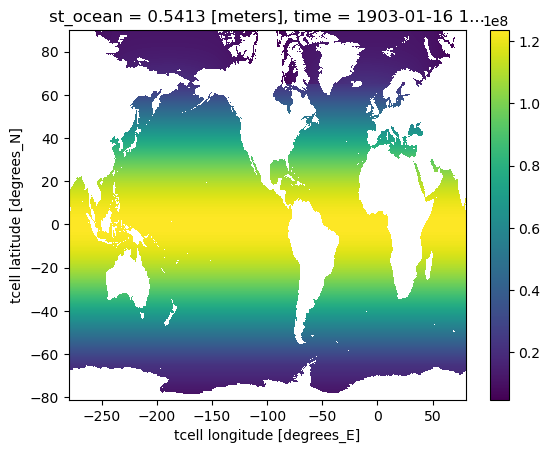

In [9]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [10]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [11]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

# Water mass flux only.

In [53]:
water_C = cont['pme_river']
water_M = melt['pme_river']

In [12]:
water_shelf_C = water_C.where(shelf_mask ==1)
water_shelf_M = water_M.where(shelf_mask ==1)

In [13]:
# Spatial average
water_time_C = (area_corr * water_shelf_C).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
water_time_M = (area_corr * water_shelf_M).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [14]:
water_time_C

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [15]:
water_time_C = water_time_C.load()
water_time_M = water_time_M.load()

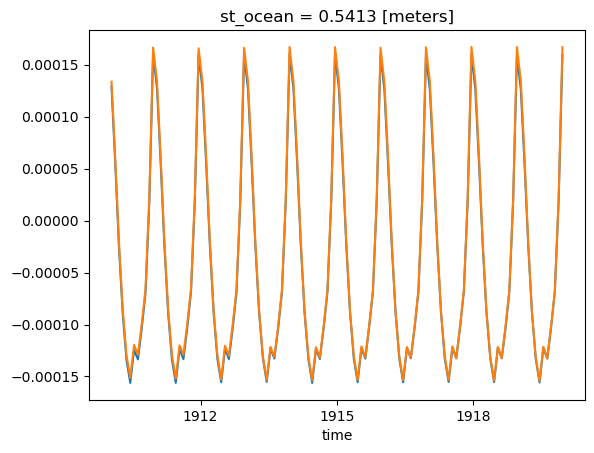

In [16]:
water_time_C.plot()
water_time_M.plot()

In [17]:
water_shelf_anom = water_time_M - water_time_C
water_shelf_anom = water_shelf_anom.load()

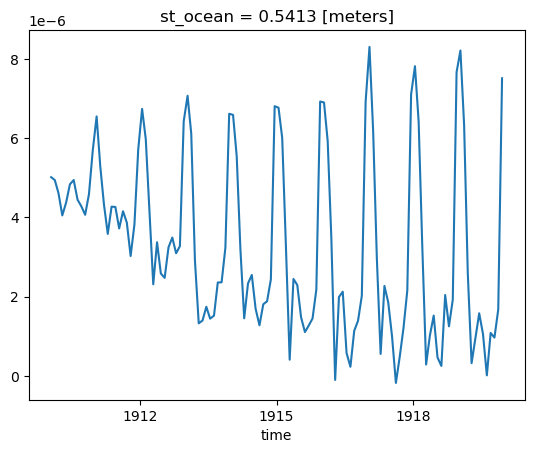

In [18]:
water_shelf_anom.plot()

In [19]:
water_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_ACCESS.nc')

# Salinity Surface flux

Components for surface flux:
- pme_river (mass water flux) **-> converted to salt flux in restoring notebook**
- pme_correct (fresh water prescribed restoring) **-> converted to salt flux in restoring notebook**
- sfc_salt_flux_ice (salt flux)

In [54]:
con_river = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/pme_river_salt_con_prescribed_access.nc')
melt_river = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/pme_river_salt_melt_prescribed_access.nc')

In [55]:
# Test with fixed restoring calculated from pme_correct
con_restore = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_access.nc')
melt_restore = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_correct_melt_prescribed_access.nc')

In [56]:
melt_river

<xarray.DataArray (time: 120, yt_ocean: 483, xt_ocean: 3600)> Size: 2GB
[208656000 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [60]:
melt_restore

<xarray.DataArray (time: 117, yt_ocean: 483, xt_ocean: 3600)> Size: 2GB
[203439600 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * time      (time) object 936B 1910-04-16 00:00:00 ... 1919-12-16 12:00:00

In [58]:
melt['runoff'].sel(yt_ocean=slice(-80,-59))

<xarray.DataArray 'runoff' (time: 120, yt_ocean: 483, xt_ocean: 3600)> Size: 835MB
dask.array<getitem, shape=(120, 483, 3600), dtype=float32, chunksize=(3, 483, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00
Attributes:
    long_name:      mass flux of liquid river runoff entering ocean
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux_into_sea_water_from_rivers

In [33]:
salt_C = cont['sfc_salt_flux_ice'] + con_restore + con_river - cont['runoff'].sel(yt_ocean=slice(-80,-59))
salt_M = melt['sfc_salt_flux_ice'] + melt_restore + melt_river - melt['runoff'].sel(yt_ocean=slice(-80,-59))

In [34]:
salt_shelf_C = salt_C.where(shelf_mask == 1)
salt_shelf_M = salt_M.where(shelf_mask == 1)

In [35]:
# Spatial average
salt_time_C = (area_corr * salt_shelf_C).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
salt_time_M = (area_corr * salt_shelf_M).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [38]:
salt_time_C

<xarray.DataArray (time: 120)> Size: 960B
array([-1.50970633e-04, -8.00667209e-05, -1.42219264e-06,  6.14134163e-05,
        1.04621863e-04,  1.26221418e-04,  9.20230638e-05,  1.00466400e-04,
        7.05941818e-05,  3.63414731e-05, -5.13757228e-05, -1.86344419e-04,
       -1.49989242e-04, -7.95395222e-05, -1.69723200e-06,  6.15410375e-05,
        1.04341901e-04,  1.26146817e-04,  9.11648741e-05,  1.00169062e-04,
        7.01753156e-05,  3.51900077e-05, -5.15885106e-05, -1.85630910e-04,
       -1.49252142e-04, -7.93387579e-05, -1.94572760e-06,  6.09485703e-05,
        1.03875987e-04,  1.25493747e-04,  9.03007159e-05,  1.00093716e-04,
        7.03471489e-05,  3.58957224e-05, -5.13971984e-05, -1.85647376e-04,
       -1.49853327e-04, -7.95307835e-05, -2.19343354e-06,  6.05408203e-05,
        1.02837386e-04,  1.24955209e-04,  9.01914771e-05,  9.94188247e-05,
        7.02695437e-05,  3.53825473e-05, -5.14206735e-05, -1.86023829e-04,
       -1.49891396e-04, -8.01836081e-05, -1.80955817e-06,  6.11575049e-05,
        1.03741331e-04,  1.26186581e-04,  9.09403807e-05,  9.98884769e-05,
        7.00646878e-05,  3.54532873e-05, -5.17584976e-05, -1.85657714e-04,
       -1.49501641e-04, -7.94900608e-05, -1.90502002e-06,  6.06922944e-05,
        1.03762335e-04,  1.25376314e-04,  8.98422260e-05,  9.95069337e-05,
        6.94259101e-05,  3.52790364e-05, -5.16325159e-05, -1.85037371e-04,
       -1.48769085e-04, -7.89984155e-05, -2.05125951e-06,  6.02075464e-05,
        1.03552342e-04,  1.25415136e-04,  8.96074303e-05,  9.91587020e-05,
        6.97394881e-05,  3.51826954e-05, -5.20346970e-05, -1.85447536e-04,
       -1.48285271e-04, -7.95162527e-05, -2.51672103e-06,  6.06383027e-05,
        1.03400592e-04,  1.24965548e-04,  8.93050262e-05,  9.90452679e-05,
        6.89392021e-05,  3.47677773e-05, -5.19726894e-05, -1.85787823e-04,
       -1.48865006e-04, -7.96096914e-05, -2.16234890e-06,  6.05834398e-05,
        1.02897234e-04,  1.25056018e-04,  8.92539594e-05,  9.91894551e-05,
        6.99063416e-05,  3.49447334e-05, -5.22093142e-05, -1.85117919e-04,
       -1.49411658e-04, -8.00549401e-05, -2.64022405e-06,  6.08990606e-05,
        1.03307204e-04,  1.25408985e-04,  8.95881125e-05,  9.92181092e-05,
        6.96565715e-05,  3.49634651e-05, -5.21212668e-05, -1.85291260e-04])
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [37]:
salt_time_C = salt_time_C.load()
salt_time_M = salt_time_M.load()

In [39]:
salt_time_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_C_3_prescribed_ACCESS.nc')
salt_time_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_salt_time_M_3_prescribed_ACCESS.nc')

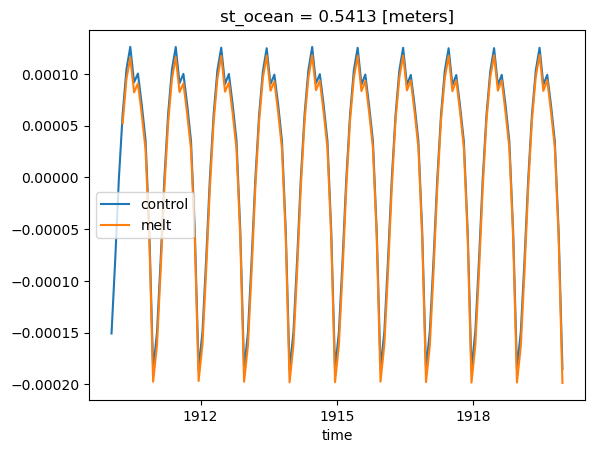

In [40]:
salt_time_C.plot(label='control')
salt_time_M.plot(label = 'melt')
plt.legend()

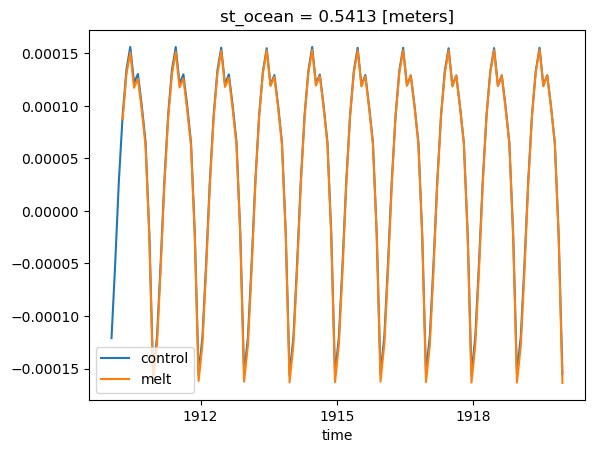

In [22]:
salt_time_C.plot(label='control')
salt_time_M.plot(label = 'melt')
plt.legend()

In [23]:
salt_shelf_anom = salt_time_M - salt_time_C
salt_shelf_anom = salt_shelf_anom.load()

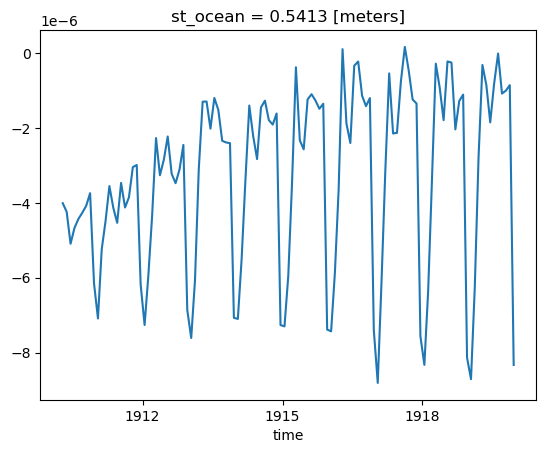

In [24]:
salt_shelf_anom.plot()

In [25]:
salt_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_prescribed_ACCESS.nc')

Old salt flux only plots:

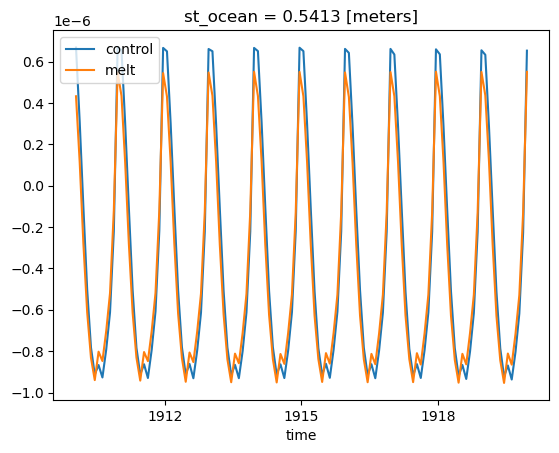

In [22]:
salt_time_C.plot(label='control')
salt_time_M.plot(label = 'melt')
plt.legend()

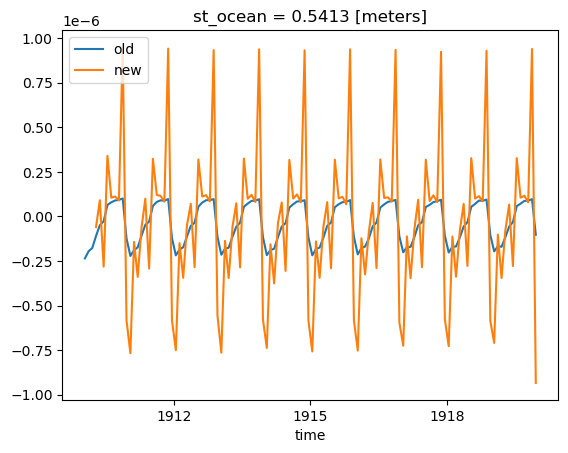

In [28]:
salt_shelf_anom.plot(label = 'old')
salt_shelf_anom_new.plot(label = 'new')
plt.legend()

Okay new version looks wrong? Units are same. So maybe correct?

In [29]:
salt_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/saltflux_shelf_time_prescribed_ACCESS.nc')

# Fixed surface flux

What I had saved is:

- `sfc_salt_flux_ice` (as salt flux)
- `runoff` which is a FW flux
- restoring_con (saved as a FW flux, sign reversed)
- restoring_correct_melt (saved as a freshwater flux, sign reversed)
- pme_river_con (saved as a freshwater flux, sign reversed)
- pme_river_melt (saved as a freshwater flux, sign reversed)

What I currently have is:
- `runoff` which is already a FW flux
- `pme_river` which is already a FW flux
- `pme_correct` - already a FW flux? Not loading in though, so instead use below:
    - restoring_con/restoring_correct_melt - a FW flux saved with reverse sign
- flux_ice_melt/flux_ice_con
    - Took `sfc_salt_flux_ice` and converted to a true freshwater flux (e.g. positive = freshening)

In [12]:
flux_ice_melt = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/flux_ice_melt_prescribed_access.nc')
flux_ice_con = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/flux_ice_con_prescribed_access.nc')

In [16]:
restore_cont = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_access.nc')
restoring_cont = -restore_cont
restore_melt = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_correct_melt_prescribed_access.nc')
restoring_melt = -restore_melt

In [18]:
surface_flux_C = flux_ice_con + cont['pme_river'] + restoring_cont - cont['runoff']
surface_flux_M = flux_ice_melt + melt['pme_river']+ restoring_melt - melt['runoff']

In [19]:
shelf_flux_C = surface_flux_C.where(shelf_mask == 1)
shelf_flux_M = surface_flux_M.where(shelf_mask == 1)

In [20]:
# Spatial average
shelf_flux_time_C = (area_corr * shelf_flux_C).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_flux_time_M = (area_corr * shelf_flux_M).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [21]:
shelf_flux_time_C = shelf_flux_time_C.load()

In [22]:
shelf_flux_time_M = shelf_flux_time_M.load()

In [23]:
shelf_flux_time_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_newtest_prescribed_ACCESS.nc')

In [24]:
shelf_flux_time_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_newtest_prescribed_ACCESS.nc')

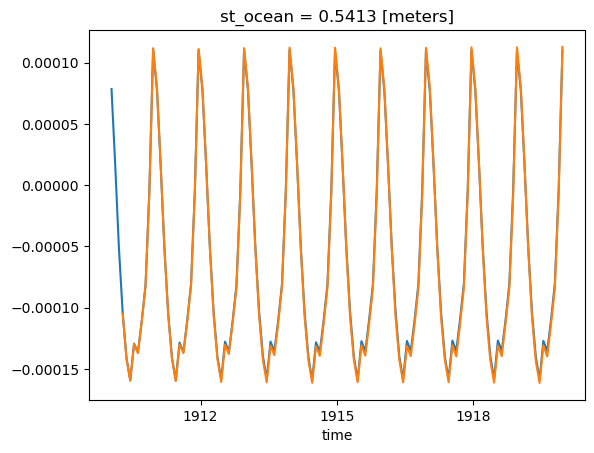

In [25]:
shelf_flux_time_C.plot()
shelf_flux_time_M.plot()